Object Detection Tutorial
=========================

This document is based on [ChainerCV's official document](http://chainercv.readthedocs.io/en/stable/tutorial/detection.html).

This tutorial will walk you through the features related to object detection that ChainerCV supports.
We assume that readers have a basic understanding of Chainer framework (e.g. understand [chainer.Link](https://docs.chainer.org/en/stable/reference/generated/chainer.Link.html)).
For users new to Chainer, please first read [Introduction to Chainer](https://docs.chainer.org/en/stable/tutorial/basic.html#write-a-model-as-a-chain).

In ChainerCV, we define the object detection task as a problem of, given an image, bounding box based localization and categorization of objects.
ChainerCV supports the task by providing the following features:

+ Visualization
+ BboxDataset
+ Detection Link
+ DetectionEvaluator
+ Training script for various detection models

Here is a short example that conducts inference and visualizes output.
Please setup Chainer and ChainerCV as follows, then download an image from the following URL and name it as `sample.jpg`.

https://cloud.githubusercontent.com/assets/2062128/26187667/9cb236da-3bd5-11e7-8bcf-7dbd4302e2dc.jpg


In [0]:
!curl https://colab.chainer.org/install | sh -! wget -O  sample.jpg https://cloud.githubusercontent.com/assets/2062128/26187667/9cb236da-3bd5-11e7-8bcf-7dbd4302e2dc.jpg

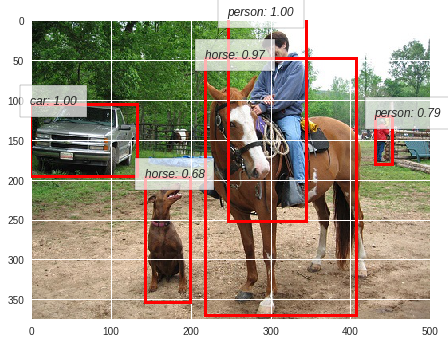

In [0]:
    # In the rest of the tutorial, we assume that the `plt`
    # is imported before every code snippet.
    import matplotlib.pyplot as plt

    from chainercv.datasets import voc_bbox_label_names
    from chainercv.links import SSD300
    from chainercv.utils import read_image
    from chainercv.visualizations import vis_bbox

    # Read an RGB image and return it in CHW format.
    img = read_image('sample.jpg')
    model = SSD300(pretrained_model='voc0712')
    bboxes, labels, scores = model.predict([img])
    vis_bbox(img, bboxes[0], labels[0], scores[0],
             label_names=voc_bbox_label_names)
    plt.show()

# Bounding boxes in ChainerCV

Bounding boxes in an image are represented as a two-dimensional array of shape $(R,4)$, where $R$ is the number of bounding boxes and the second axis corresponds to the coordinates of bounding boxes. The coordinates are ordered in the array by `(y_min, x_min, y_max, x_max)`, where `(y_min, x_min)` and `(y_max, x_max)` are the `(y, x)` coordinates of the top left and the bottom right vertices. Notice that ChainerCV orders coordinates in `yx` order, which is the opposite of the convention used by other libraries such as OpenCV. This convention is adopted because it is more consistent with the memory order of an image that follows row-column order. Also, the dtype of bounding box array is `numpy.float32`.

Here is an example with a simple toy data.



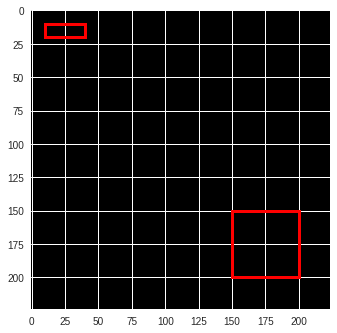

In [0]:
from chainercv.visualizations import vis_bbox
import numpy as np

img = np.zeros((3, 224, 224), dtype=np.float32)
# We call a variable/array of bounding boxes as `bbox` throughout the library
bbox = np.array([[10, 10, 20, 40], [150, 150, 200, 200]], dtype=np.float32)

vis_bbox(img, bbox)
plt.show()

In this example, two bounding boxes are displayed on top of a black image. `vis_bbox()` is a utility function that visualizes bounding boxes and an image together.

# Bounding Box Dataset

ChainerCV supports dataset loaders, which can be used to easily index examples with list-like interfaces. Dataset classes whose names end with `BboxDataset` contain annotations of where objects locate in an image and which categories they are assigned to. These datasets can be indexed to return a tuple of an image, bounding boxes and labels. The labels are stored in an `np.int32` array of shape $(R,)$. Each element corresponds to a label of an object in the corresponding bounding box.

A mapping between an integer label and a category differs between datasets. This mapping can be obtained from objects whose names end with `label_names`, such as `voc_bbox_label_names`. These mappings become helpful when bounding boxes need to be visualized with label names. In the next example, the interface of `BboxDataset` and the functionality of `vis_bbox()` to visualize label names are illustrated.



(2, 4)
(2,)


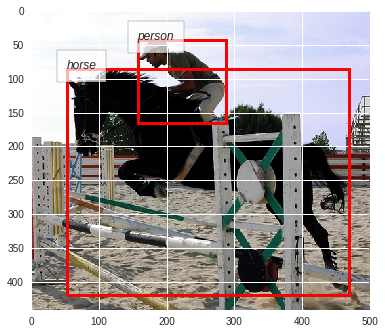

In [0]:
from chainercv.datasets import VOCBboxDataset
from chainercv.datasets import voc_bbox_label_names
from chainercv.visualizations import vis_bbox

dataset = VOCBboxDataset(year='2012')
img, bbox, label = dataset[0]
print(bbox.shape)  # (2, 4)
print(label.shape)  # (2,)
vis_bbox(img, bbox, label, label_names=voc_bbox_label_names)
plt.show()

Note that the example downloads VOC 2012 dataset at runtime when it is used for the first time on the machine.

# Detection Link

ChainerCV provides several network implementations that carry out object detection. For example, Single Shot MultiBox Detector (SSD) [Liu16] and Faster R-CNN [Ren15] are supported. Despite the difference between the models in how prediction is carried out internally, they support the common method for prediction called `predict()`. This method takes a list of images and returns prediction result, which is a tuple of lists `bboxes, labels, scores`. The more description can be found here (`predict()`). Inference on these models runs smoothly by downloading necessary pre-trained weights from the internet automatically.

From: http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
To: /content/.chainer/dataset/_dl_cache/c320d1dc0cd031efc99e256bf21d57a6
  %   Total    Recv       Speed  Time left
  1  430MiB    3MiB   2638KiB/s    0:02:45

100  430MiB  429MiB   4392KiB/s    0:00:00

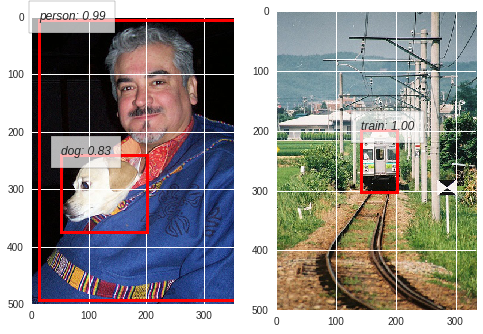

In [0]:
from chainercv.datasets import VOCBboxDataset
from chainercv.datasets import voc_bbox_label_names
from chainercv.links import SSD300
from chainercv.visualizations import vis_bbox

dataset = VOCBboxDataset(year='2007', split='test')
img_0, _, _ = dataset[0]
img_1, _, _ = dataset[1]
model = SSD300(pretrained_model='voc0712')
# Note that `predict` takes a list of images.
bboxes, labels, scores = model.predict([img_0, img_1])

# Visualize output of the first image on the left and
# the second image on the right.
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
vis_bbox(img_0, bboxes[0], labels[0], scores[0],
         label_names=voc_bbox_label_names, ax=ax1)
vis_bbox(img_1, bboxes[1], labels[1], scores[1],
         label_names=voc_bbox_label_names, ax=ax2)
plt.show()

The above example puts together functionality of detection link. It instantiates SSD300 model with weights trained on VOC 2007 and VOC 2012 datasets. The model runs prediction using `predict()`, and the outputs are visualized using `vis_bbox()`. Note that in this case, confidence scores are visualized together with other data.

Many detection algorithms post-process bounding box proposals calculated from the output of neural networks by removing unnecessary ones. Faster R-CNN and SSD use non-maximum suppression to remove overlapping bounding boxes. Also, they remove bounding boxes with low confidence scores. These two models have attributes `nms_thresh` and `score_thresh`, which configure the post-processing. In the following example, the algorithm runs with a very low `score_thresh` so that bounding boxes with low scores are kept. It is known that lower `score_thresh` produces higher mAP.

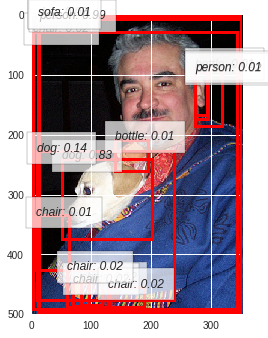

In [0]:
from chainercv.datasets import VOCBboxDataset
from chainercv.datasets import voc_bbox_label_names
from chainercv.links import SSD300
from chainercv.visualizations import vis_bbox

dataset = VOCBboxDataset(year='2007', split='test')
img, _, _ = dataset[0]
model = SSD300(pretrained_model='voc0712')
# Alternatively, you can use predefined parameters by
# model.use_preset('evaluate')
model.score_thresh = 0.01
bboxes, labels, scores = model.predict([img])
vis_bbox(img, bboxes[0], labels[0], scores[0],
         label_names=voc_bbox_label_names)
plt.show()

# Detection Evaluator

ChainerCV provides functionalities that make evaluating detection links easy. They are provided at two levels: evaluator extensions and evaluation functions.

Evaluator extensions such as `DetectionVOCEvaluator` inherit from `Evaluator`, and have similar interface. They are initialized by taking an iterator and a network that carries out prediction with method `predict()`. When this class is called (i.e. `__call__()` of `DetectionVOCEvaluator`), several actions are taken. First, it iterates over a dataset based on an iterator. Second, the network makes prediction using the images collected from the dataset. Last, an evaluation function is called with the ground truth annotations and the prediction results.

In contrast to evaluators that hide details, evaluation functions such as `eval_detection_voc()` are provided for those who need a finer level of control. These functions take the ground truth annotations and prediction results as arguments and return measured performance.

Here is a simple example that uses a detection evaluator.

In [0]:
from chainer.iterators import SerialIterator
from chainer.datasets import SubDataset
from chainercv.datasets import VOCBboxDataset
from chainercv.datasets import voc_bbox_label_names
from chainercv.extensions import DetectionVOCEvaluator
from chainercv.links import SSD300

# Only use subset of dataset so that evaluation finishes quickly.
dataset = VOCBboxDataset(year='2007', split='test')
dataset = dataset[:6]
it = SerialIterator(dataset, 2, repeat=False, shuffle=False)
model = SSD300(pretrained_model='voc0712')
evaluator = DetectionVOCEvaluator(it, model,
                                  label_names=voc_bbox_label_names)
# result is a dictionary of evaluation scores. Print it and check it.
result = evaluator()

# Training Detection Links

By putting together all the functions and utilities, training scripts can be easily written. Please check training scripts contained in the examples. Also, ChainerCV posts the performance achieved through running the training script in README.

* [Faster R-CNN examples](https://github.com/chainer/chainercv/tree/master/examples/faster_rcnn)
* [SSD examples](https://github.com/chainer/chainercv/tree/master/examples/ssd)

# References

* [Ren15] Shaoqing Ren, Kaiming He, Ross Girshick, Jian Sun. Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks. NIPS 2015.
* [Liu16]	Wei Liu, Dragomir Anguelov, Dumitru Erhan, Christian Szegedy, Scott Reed, Cheng-Yang Fu, Alexander C. Berg. SSD: Single Shot MultiBox Detector. ECCV 2016.